In [1]:
## IMPORTS
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import Image

In [2]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [3]:
torch.manual_seed(1337)
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
dropout = 0.1
# ------------

In [4]:

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

    
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x
    

# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [5]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out['train'], out['val']

In [6]:
train = get_batch('train')

TRAIL 1

100%|██████████| 30/30 [00:44<00:00,  1.50s/it]


Epoch 29: train loss: 3.259, perplexity: 26.020
Epoch 29: validation loss: 3.259, perplexity: 26.019
CPU times: user 50.6 s, sys: 580 ms, total: 51.1 s
Wall time: 45.1 s


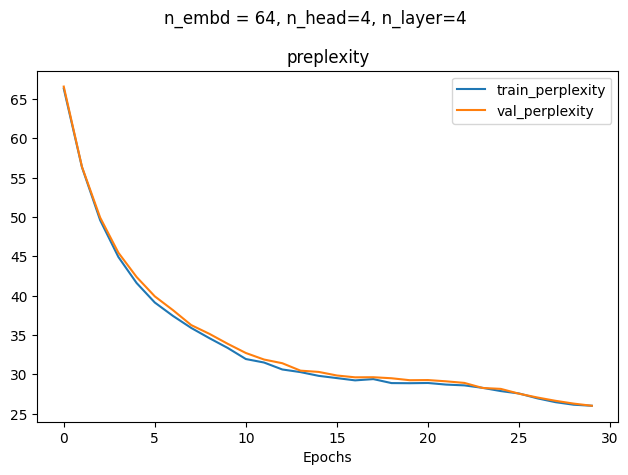

In [7]:
%%time
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
model = LanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
epochs = 30
cols = ["train_perplexity", "val_perplexity"]
training_frame = {col: [] for col in cols}
for epoch in tqdm(range(epochs)):
    model.train()
    _, loss = model.forward(train[0], train[1])
    loss.backward()
    optimizer.step() 
    train_loss, val_loss = estimate_loss()
    train_perplexity = torch.exp(train_loss); val_perplexity = torch.exp(val_loss)
    training_frame["train_perplexity"].append(train_perplexity.item()); training_frame["val_perplexity"].append(val_perplexity.item())
print(f"Epoch {epoch}: train loss: {train_loss:.3f}, perplexity: {train_perplexity:.3f}" )
print(f"Epoch {epoch}: validation loss: {val_loss:.3f}, perplexity: {val_perplexity:.3f}")
training_frame = pd.DataFrame(training_frame)
fig1, axs = plt.subplots()
title = f"n_embd = {n_embd}, n_head={n_head}, n_layer={n_layer}"
plt.suptitle(title)
training_frame.plot(y=["train_perplexity", "val_perplexity"], ax=axs, xlabel='Epochs', title="preplexity")
plt.tight_layout()
name = 'hw5_fig1.png'
fig1.savefig(name)
# Image(name)

TRIAL 2: Increase the number of layers --> See a lower perplexity score

In [ ]:
%%time
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 8
model = LanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
epochs = 30
cols = ["train_perplexity", "val_perplexity"]
training_frame = {col: [] for col in cols}
for epoch in tqdm(range(epochs)):
    model.train()
    _, loss = model.forward(train[0], train[1])
    loss.backward()
    optimizer.step() 
    train_loss, val_loss = estimate_loss()
    train_perplexity = torch.exp(train_loss); val_perplexity = torch.exp(val_loss)
    training_frame["train_perplexity"].append(train_perplexity.item()); training_frame["val_perplexity"].append(val_perplexity.item())
print(f"Epoch {epoch}: train loss: {train_loss:.3f}, perplexity: {train_perplexity:.3f}" )
print(f"Epoch {epoch}: validation loss: {val_loss:.3f}, perplexity: {val_perplexity:.3f}")
training_frame = pd.DataFrame(training_frame)
fig2, axs = plt.subplots()
title = f"n_embd = {n_embd}, n_head={n_head}, n_layer={n_layer}"
plt.suptitle(title)
training_frame.plot(y=["train_perplexity", "val_perplexity"], ax=axs, xlabel='Epochs', title="preplexity")
plt.tight_layout()
name = 'hw5_fig2.png'
fig2.savefig(name)
# Image(name)

 80%|████████  | 24/30 [01:07<00:16,  2.80s/it]

TRIAL 3: Increase the embedding dimension

In [ ]:
%%time
n_embd = 128
n_head = 4 ## so head_size = 16
n_layer = 8
model = LanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
epochs = 40
cols = ["train_perplexity", "val_perplexity"]
training_frame = {col: [] for col in cols}
for epoch in tqdm(range(epochs)):
    model.train()
    _, loss = model.forward(train[0], train[1])
    loss.backward()
    optimizer.step() 
    train_loss, val_loss = estimate_loss()
    train_perplexity = torch.exp(train_loss); val_perplexity = torch.exp(val_loss)
    training_frame["train_perplexity"].append(train_perplexity.item()); training_frame["val_perplexity"].append(val_perplexity.item())
print(f"Epoch {epoch}: train loss: {train_loss:.3f}, perplexity: {train_perplexity:.3f}" )
print(f"Epoch {epoch}: validation loss: {val_loss:.3f}, perplexity: {val_perplexity:.3f}")
training_frame = pd.DataFrame(training_frame)
fig, axs = plt.subplots()
title = f"n_embd = {n_embd}, n_head={n_head}, n_layer={n_layer}"
plt.suptitle(title)
training_frame.plot(y=["train_perplexity", "val_perplexity"], ax=axs, xlabel='Epochs', title="preplexity")
plt.tight_layout()
name = 'hw5_fig3.png'
fig.savefig(name)
# Image(name)